# In Class Assignment 1

Use the given 1-nearest neighbor classifier which estimates a penguins `species` by observing its `bill_depth_mm` and `bill_length_mm` to:
- Plot a confusion matrix which shows the performance of your classifier
- In a few sentences, explain whether this confusion matrix accurately represents the performance of the classifier on new penguins?  Why or why not?  How might you fix this issue?

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

df_penguin = sns.load_dataset('penguins')
df_penguin.dropna(how='any', inplace=True)

In [2]:
from sklearn.neighbors import KNeighborsClassifier

k = 1
x_feat_list = ['bill_depth_mm', 'bill_length_mm']
y_feat = 'species'

x = df_penguin.loc[:, x_feat_list].values
y_true = df_penguin.loc[:, y_feat].values

# initialize a knn_classifier
knn_classifier = KNeighborsClassifier(n_neighbors=k)

# fit happens "inplace", we modify the internal state of knn_classifier to remember all the training samples
knn_classifier.fit(x, y_true)

# estimate each penguin's species
y_pred = knn_classifier.predict(x)

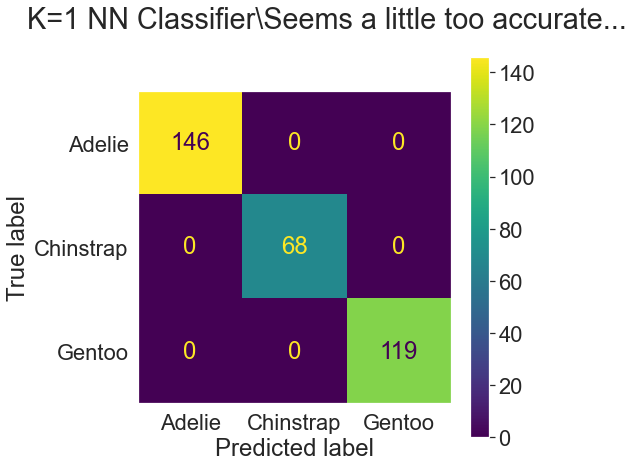

In [3]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np

conf_mat = confusion_matrix(y_true=y_true, y_pred=y_pred)
conf_mat_disp = ConfusionMatrixDisplay(conf_mat, display_labels=np.unique(y_true))

sns.set(font_scale=2)
conf_mat_disp.plot()
plt.suptitle('K=1 NN Classifier\Seems a little too accurate...')

plt.gcf().set_size_inches(7, 7)

# seaborn turns on grid by default ... looks best without it
plt.grid(False)


This confusion matrix does not accurately represents the performance of the 
classifier on new penguins. It is too accurate as there are no inccurate prediction to 
true labels (Adelie/Gentoo, Adelie/Chinstrap, Chinstrap/Gentoo, Chinstrap/Adelie,
Gentoo/Chinstrap, Gentoo/Adelie). We trained the classifier and predicted with the classifier
with the same data. So, the nearest neighbor would just be the point itself. Each penguin is its
own nearest neighbor.

# In Class Assignment 2

One question we never answered: How do we pick the best K for a K-NN classifier?

A common solution is to try many different k and then choose the one which works "best".

<img src="https://i.ibb.co/2sc080h/best-k-penguin.png">

In this ICA, make this plot of the **cross validated** accuracy of the k-NN classifier for k = 1 to 50.
- in your cross validation, use `n_splits=10` folds of data
- write a function `get_cv_acc_knn()` which:
    - accepts:
        - `x`, `y_true`, `k` as defined above
            - outside of the function, we'll stick with the same classification problem where we estimate `species` from `bill_depth_mm` and `bill_length_mm`
        - `n_splits=10` (default)
    - returns 
        - the cross validated accuracy of k-NN on the dataset    
- use this function to build the plot above by looping over k = 1 to 50

In [4]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from collections import Counter
import matplotlib.pyplot as plt

In [5]:
k = 1
x_feat_list = ['bill_depth_mm', 'bill_length_mm']
y_feat = 'species'

x = df_penguin.loc[:, x_feat_list].values
y_true = df_penguin.loc[:, y_feat].values

In [6]:
def get_cv_acc_knn(x, y_true, k, n_splits=10):

    # initialize a knn_classifier
    knn_classifier = KNeighborsClassifier(n_neighbors=k)

    # "stratified" ensures (roughly same number of species across folds
    # otherwise we could get funny results with all 'Adelie' penguins in one fold
    kfold = StratifiedKFold(n_splits=n_splits)

    # initialize an empty array same size as y_true
    y_pred = np.empty_like(y_true)
    
    for train_idx, test_idx in kfold.split(x, y_true):
        # index to split training / test data
        x_train = x[train_idx, :]
        x_test = x[test_idx, :]
        y_true_train = y_true[train_idx]

        # fit happens "inplace", we modify the internal state of knn_classifier to remember all the training samples
        knn_classifier.fit(x_train, y_true_train)

        # estimate each penguin's species
        y_pred[test_idx] = knn_classifier.predict(x_test)
    
    return accuracy_score(y_true, y_pred)
    

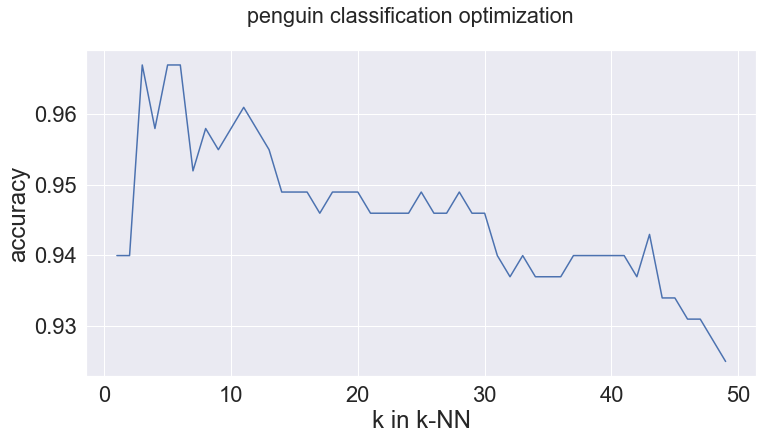

In [7]:
ks = []
accs = []

for k in range(1, 50):
    ks.append(k)
    accs.append(get_cv_acc_knn(x, y_true, k))
    
plt.plot(ks, accs)

# labels and size
sns.set(font_scale=1.5)
plt.ylabel('accuracy')
plt.xlabel('k in k-NN')
plt.suptitle('penguin classification optimization')
plt.gcf().set_size_inches(12, 6)

plt.show()

## Intercontinental Ballistic Missile (ICBM)

In [8]:
# 'secret' slide: how we generated the icbm data

import pandas as pd
import numpy as np

# total samples
n = 100000

# prior prob of icbm event
prior = .01

# false alarm and detection (sensitivity) rates
fa_detect = [(.1, .99), (.5, .95), (.8, 1), (.07, .95)]

# sample n icbm events
rng = np.random.default_rng(seed=0)
icbm = rng.random(n) < prior

# init dataframe
df_icbm = pd.DataFrame({'icbm': icbm})

for test_idx, (fa, detect) in enumerate(fa_detect):
    pred = np.empty_like(icbm)
    
    # get predictions (depend on icbm state)
    pred[icbm] = np.random.rand(icbm.sum()) < detect
    pred[~icbm] = np.random.rand((~icbm).sum()) < fa
    
    # store predictions
    df_icbm[f'alarm{test_idx}'] = pred
    
df_icbm.to_csv('icbm.csv', index=False)

In [9]:
from sklearn.metrics import confusion_matrix

def get_acc_sens_spec(y_true, y_pred, verbose=True):
    """ computes sensitivity & specificity (assumed binary inputs)

    Args:
        y_true (np.array): binary ground truth per trial
        y_pred (np.array): binary prediction per trial

    Returns:
        acc (float): accuracy
        sens (float): sensitivity
        spec (float): specificity
    """
    # line below stolen from sklearn confusion_matrix documentation
    tn, fp, fn, tp = confusion_matrix(y_true.astype(bool),
                                      y_pred.astype(bool),
                                      labels=(0, 1)).ravel()

    # compute sensitivity
    if tp + fn:
        sens = tp / (tp + fn)
    else:
        sens = np.nan

    # compute specificity
    if tn + fp:
        spec = tn / (tn + fp)
    else:
        spec = np.nan
        
    # compute acc
    acc = (tp + tn) / (tn + fp + fn + tp)

    return acc, sens, spec

In [10]:
df_icbm = pd.read_csv('icbm.csv')
df_icbm.head()

,icbm,alarm0,alarm1,alarm2,alarm3
0,False,False,True,True,False
1,False,False,False,True,False
2,False,False,True,True,False
3,False,False,False,True,False
4,False,True,False,True,False


In [11]:
df_performance = pd.DataFrame()
for idx in range(4):
    alarm = f'alarm{idx}'
    
    # get truth / predict for alarm
    truth = df_icbm.loc[:, 'icbm']
    pred = df_icbm.loc[:, alarm]
    
    # build dataframe of accuracy, sensitivity and specificity
    acc, sens, spec = get_acc_sens_spec(y_true=truth, y_pred=pred)
    df_performance.loc[alarm, 'accuracy'] = acc
    df_performance.loc[alarm, 'sensitivity'] = sens
    df_performance.loc[alarm, 'specificity'] = spec
    
df_performance

,accuracy,sensitivity,specificity
alarm0,0.90187,0.984802,0.901043
alarm1,0.50336,0.945289,0.498955
alarm2,0.20643,1.000000,0.198519
alarm3,0.92830,0.944276,0.928141


## In Class Exercise 3

Using the values above (and maybe other operations on the dataframe too) select which of the four alarm systems is most appropriate to detect ICBMs.  Provide an explanation which is easily understood by a non-technical reader.

Is there any other information you'd need to make this decision?

Specificity is the most important in this scenario. 
Alarm 3 is the most appropriate to detech ICBMs since
it has the highest specificity. There is a low chance of missing
an incoming missile and will not give a lot fo false alarms since the
specificity is relatively high.